#### JSE listed companies 
      :Netcare limited group
      :Santam limited
      :Sanlam group limited 
      :Nedbank Group Ltd

# Netcare Limited
Netcare (Network Healthcare Holdings Limited) is a South African health care company. It is the largest provider of private healthcare (ahead of LIFE Healthcare, formally known as Afrox Healthcare and Mediclinic International) in both South Africa and the United Kingdom. It acquired a controlling stake in the UK's General Healthcare Group in 2006, and provides services to the National Health Service via its subsidiary General Healthcare Group

In [1]:
#importing the modules in python
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
%matplotlib inline
import warnings

#load the data 
filename = 'ntc.csv'
netcareTS = pd.read_csv(filename,na_filter=True,index_col="Date").dropna()
netcareTS.head(5)



,Open,High,Low,Close,Volume
Date,,,,,
13/01/02,1985,1990,1963,1975.0,514952
13/01/03,1974,1976,1960,1970.0,584990
13/01/04,1969,2011,1954,2000.0,3130465
13/01/07,2005,2010,1977,1990.0,1483949
13/01/08,2000,2000,1986,2000.0,1269313


$\textbf{Plot the closing prices}$

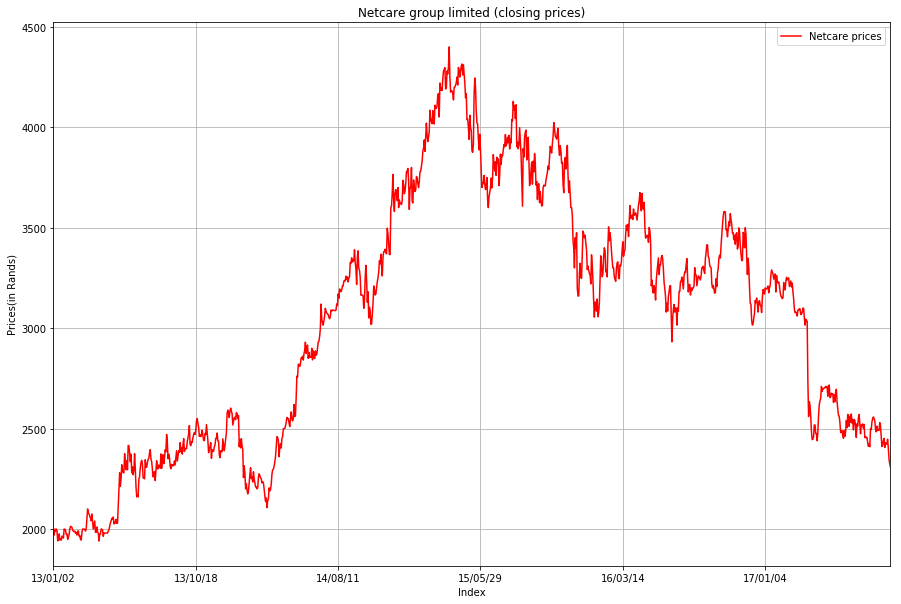

In [2]:
plt.figure(figsize=(15,10))
netcareTS["Close"].plot(label="Netcare prices",color="red")
plt.grid(True)
plt.title("Netcare group limited (closing prices)",color="black")
plt.xlabel("Index")
plt.ylabel("Prices(in Rands)")
plt.legend(loc=1)

$\textbf{The log-returns}$ calculated as:   $r_{t}=log\Big(\frac{p_{t}}{p_{t-1}}\Big)$, where $p_{t}$ is the closing price at time $t$. To analyze the stock price, we usually calculate the logged return of the stock price(closing prices) to make the data stationary.

In [3]:
#The log-returns
returns=np.log((netcareTS["Close"])/(netcareTS["Close"].shift()))
returns.head(5)
returns=returns.dropna()

The following plot shows the daily logged return of Netcare group limited


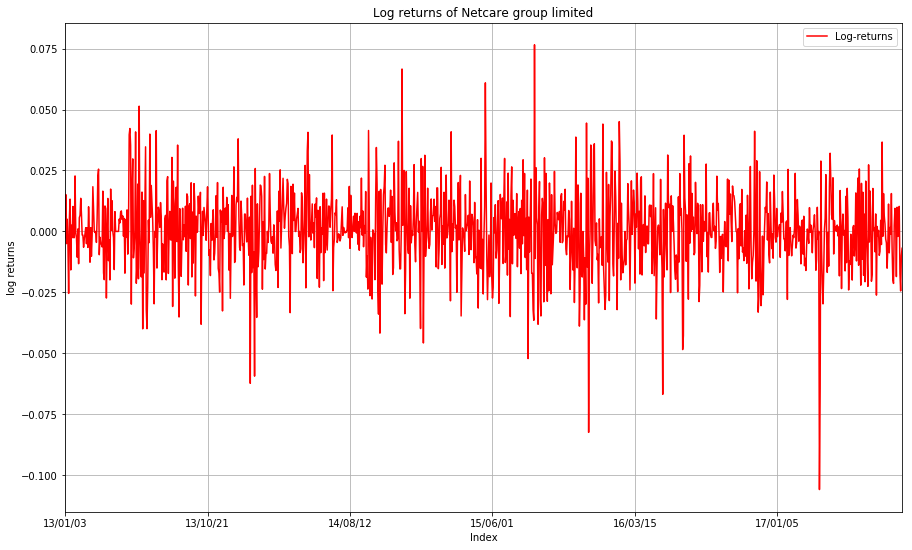

In [4]:
print("The following plot shows the daily logged return of Netcare group limited")
plt.figure(figsize=(15,9))
returns.plot(label="Log-returns",color="red")
plt.grid(True)
plt.title("Log returns of Netcare group limited",color="black")
plt.xlabel("Index")
plt.ylabel("log returns")
plt.legend(loc=0)
plt.show()

$\textbf{Test for stationarity of returns}$: Augmented dickey fuller, Philips perron tests

In [5]:
#stationarity test for the returns series
#The number of lags can be directly set using lags.
#Changing the number of lags makes no difference to the conclusion
#The ADF assumes residuals are white noise, and that the number of lags is sufficient, 
#to pick up any dependence  in the data.

from arch.unitroot import ADF
adf = ADF(returns)
adf.lags = 15
print(adf.summary().as_text())
print('The ADF test statistic value is less than the critical region and p-value is also less than 0.05 significance level.So we  reject the null hypothesis of non-stationarity of the series and conclude that the returns series is stationary')


/home/vhahangwele/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


   Augmented Dickey-Fuller Results   
Test Statistic                 -9.050
P-value                         0.000
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
The ADF test statistic value is less than the critical region and p-value is also less than 0.05 significance level.So we  reject the null hypothesis of non-stationarity of the series and conclude that the returns series is stationary


In [6]:
#Alternative test for stationarity the Philips perron test
from arch.unitroot import PhillipsPerron
pp = PhillipsPerron(returns)
pp.lags=23
print(pp.summary().as_text())
print("The test statistic is less than critical values for all significance levels, so we reject the null hypothesis of stationarity")

     Phillips-Perron Test (Z-tau)    
Test Statistic                -36.474
P-value                         0.000
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
The test statistic is less than critical values for all significance levels, so we reject the null hypothesis of stationarity


$\textbf{Split the data into multiple training and testing sets}$

### split1: Train 500  Test:200
###  split2: Train 700  Test:200


###  State Space ARMA(1,1) Model

In [7]:
warnings.filterwarnings("ignore") 
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.tools import (constrain_stationary_univariate,
                                              unconstrain_stationary_univariate)

class ARMA11(smt.statespace.MLEModel):
    start_params=[-0.161,-0.78,1]#set initial parameters
    param_names = ['phi', 'theta', 'sigma2']#define the parameters
    
    def __init__(self, endog):
        super(ARMA11, self).__init__(
            endog, k_states=2, k_posdef=1, initialization='stationary')

        self['design', 0, 0] = 1.
        self['transition', 1, 0] = 1.
        self['selection', 0, 0] = 1.

    def transform_params(self, params):
        phi = constrain_stationary_univariate(params[0:1])
        theta = constrain_stationary_univariate(params[1:2])
        sigma2 = params[2]**2
        return np.r_[phi, theta, sigma2]

    def untransform_params(self, params):
        phi = unconstrain_stationary_univariate(params[0:1])
        theta = unconstrain_stationary_univariate(params[1:2])
        sigma2 = params[2]**0.5
        return np.r_[phi, theta, sigma2]

    def update(self, params, **kwargs):
        # Transform the parameters if they are not yet transformed
        params = super(ARMA11, self).update(params, **kwargs)

        self['design', 0, 1] = params[1]
        self['transition', 0, 0] = params[0]
        self['state_cov', 0, 0] = params[2]

#### split1: Train 500  Test:200

In [8]:
netcareTrain1=returns[0:500]
netcareTest1=returns[500:700]

In [9]:
#summary statistics of the fitted model
ARMA11_model = ARMA11(netcareTrain1.as_matrix())
Model_results = ARMA11_model.fit()

print(Model_results.summary())

print'Model: summary'
print 'Both the estimated autoregressive(phi) and moving average paramters(theta) lies within the 95%\
confidence interval. But, the varince parameter value is very small (almost close to zero).\
The mode estimated standard errors are close to zero.These results indicates that our \
estimated paramters are close to the true values'
print'We can also use the Z scores to check for significance of our estimated coefficients.\
The decision rule is that if |Z|>1.96, then we conclude that the models estimated coefficient\
is statistically significanlty different from zero. So the variable is useful in the model.'

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  500
Model:                         ARMA11   Log Likelihood                1370.640
Date:                Thu, 10 May 2018   AIC                          -2735.281
Time:                        03:32:57   BIC                          -2722.637
Sample:                             0   HQIC                         -2730.319
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
phi            0.4305      0.339      1.270      0.204      -0.234       1.095
theta         -0.5184      0.321     -1.616      0.106      -1.147       0.110
sigma2         0.0002   1.15e-05     21.239      0.0

$\textbf{Predictions (test data)}$:

In [10]:
import pandas as pd
from  pandas import Series
print("Long term predictions (test data) 25%:")
import warnings
warnings.filterwarnings("ignore") 
from numpy import sqrt
import statsmodels.tsa.api as smt

history=[x for x in netcareTrain1]
test_predicted=list()
for i in range(len(netcareTest1)):
    model=ARMA11(history).fit(trend='nc')
    output=model.forecast()
    yhat=output[0]
    obs=netcareTest1[i]
    test_predicted.append(yhat)
    history.append(obs)
    AbsoluteError=(np.abs(obs-yhat))
    ForecastError=(obs-yhat)
    print ('Test=%f, Predicted=%f' % (obs,yhat))
netcareTest1=list(netcareTest1)


Long term predictions (test data) 25%:
Test=0.029902, Predicted=0.003970
Test=0.000000, Predicted=-0.000693
Test=0.026668, Predicted=-0.000347
Test=-0.045768, Predicted=-0.002706
Test=-0.001930, Predicted=0.003307
Test=0.031248, Predicted=0.001825
Test=-0.010218, Predicted=-0.002363
Test=-0.005420, Predicted=-0.000106
Test=0.002443, Predicted=0.000531
Test=0.017733, Predicted=0.000003
Test=-0.002400, Predicted=-0.001911
Test=-0.006965, Predicted=-0.000700
Test=-0.005391, Predicted=0.000398
Test=0.007807, Predicted=0.000780
Test=0.013319, Predicted=-0.000450
Test=0.000529, Predicted=-0.001661
Test=0.006327, Predicted=-0.000966
Test=0.006549, Predicted=-0.001128
Test=0.013228, Predicted=-0.001263
Test=0.004114, Predicted=-0.002075
Test=0.010212, Predicted=-0.001430
Test=-0.014584, Predicted=-0.001755
Test=0.017880, Predicted=0.000648
Test=0.017815, Predicted=-0.001573
Test=-0.015287, Predicted=-0.002619
Test=-0.007859, Predicted=0.000336
Test=0.005331, Predicted=0.000750
Test=0.007315, P

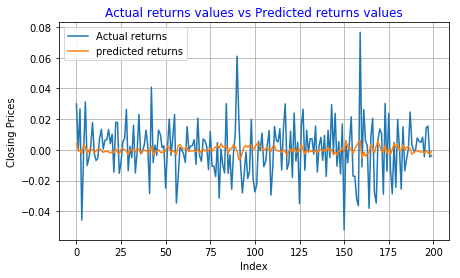

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(netcareTest1,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()

In [12]:
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))

print("Predicted data:")
#convert normalised (testing)data to binary 0 or 1
binary_test=[]
for t in range(0,len(netcareTest1)):
    if netcareTest1[t-1]>=netcareTest1[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)

([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1], 200)
Predicted data:
([1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,

(200, 200, list)

$\textbf{Count the number of correct direction predictions}$:

In [13]:
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print "The number of correct direction predictions is:",count,"out of:",len(x),"data points"
counter(binary_test,binary_predicted_test)


The number of correct direction predictions is: 154 out of: 200 data points


$\textbf{Confusion Matrix}$:

Accuracy for testing data:
77.0
[[75 19]
 [27 79]]


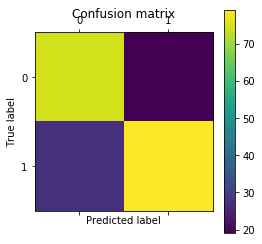

In [14]:
#accuracy decsribes: overall, how often the classifier is correct
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print("Accuracy for testing data:")
def Confusion_matrix(n):
    print(accuracy_score(binary_test[0:n],binary_predicted_test[0:n])*100)
    confusion=confusion_matrix(binary_test[0:n],binary_predicted_test[0:n])
    print(confusion) 
    #show confusion matrix
    plt.matshow(confusion)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
Confusion_matrix(len(binary_test))

In [16]:
print(classification_report(binary_test,binary_predicted_test))
#precision- when it predicts 0 how often is it correct, when it predicts 1 how often is it correct.
#recall-when its 0 how often does it predict 0, when its 1 how often does it predict 1
 #calculate the misclassification  rate
print("The misclassification rate is:",(1-accuracy_score(binary_test,binary_predicted_test))*100,'%')                                                                                

             precision    recall  f1-score   support

          0       0.74      0.80      0.77        94
          1       0.81      0.75      0.77       106

avg / total       0.77      0.77      0.77       200

('The misclassification rate is:', 23.0, '%')


#### split2: Train 700  Test:200

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  700
Model:                         ARMA11   Log Likelihood                1896.196
Date:                Thu, 10 May 2018   AIC                          -3786.392
Time:                        02:59:47   BIC                          -3772.739
Sample:                             0   HQIC                         -3781.115
                                - 700                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
phi            0.3854      0.205      1.879      0.060      -0.017       0.787
theta         -0.5182      0.189     -2.743      0.006      -0.889      -0.148
sigma2         0.0003   1.04e-05     24.910      0.0

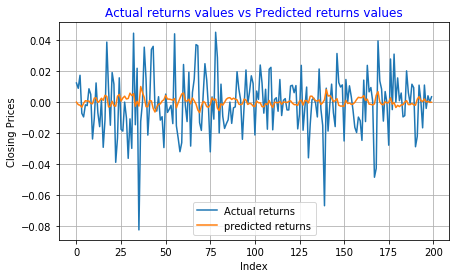

([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1], 200)
Predicted data:
([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,

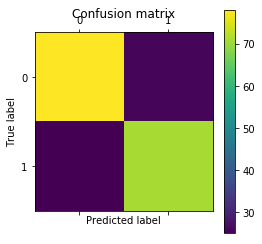

In [17]:
netcareTrain1=returns[0:700]
netcareTest1=returns[700:900]
#summary statistics of the fitted model
ARMA11_model = ARMA11(netcareTrain1.as_matrix())
Model_results = ARMA11_model.fit()
print(Model_results.summary())
import pandas as pd
from  pandas import Series
print("Long term predictions (test data) 25%:")
import warnings
warnings.filterwarnings("ignore") 
from numpy import sqrt
import statsmodels.tsa.api as smt

history=[x for x in netcareTrain1]
test_predicted=list()
for i in range(len(netcareTest1)):
    model=ARMA11(history).fit(trend='nc')
    output=model.forecast()
    yhat=output[0]
    obs=netcareTest1[i]
    test_predicted.append(yhat)
    history.append(obs)
    AbsoluteError=(np.abs(obs-yhat))
    ForecastError=(obs-yhat)
    print ('Test=%f, Predicted=%f' % (obs,yhat))
netcareTest1=list(netcareTest1)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(netcareTest1,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))

print("Predicted data:")
#convert normalised (testing)data to binary 0 or 1
binary_test=[]
for t in range(0,len(netcareTest1)):
    if netcareTest1[t-1]>=netcareTest1[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print "The number of correct direction predictions is:",count,"out of:",len(x),"data points"
counter(binary_test,binary_predicted_test)
Confusion_matrix(len(binary_test))

# Santam Ltd

Santam Ltd is an insurer covering general insurance and investment operations, as well as investments in emerging market insurance companies. The Company's segments include insurance, which includes core general insurance and reinsurance underwriting activities undertaken by the Company and are analyzed by insurance class; Investment, which includes all investment-related activities undertaken by the Company, and Strategic diversification, which relate to all strategic investing activities where the purpose of the activities is to obtain certain diversification benefits. The Company's business units include Santam Commercial and Personal, which offers business portfolio, multiproduct and multichannel distribution portfolio, and independent administration capability; Santam Specialist, which focuses on the insurance of risks in various market segments; MiWay, which is a direct insurer in the group, and Santam re, which is a wholesale reinsurance service provider

In [18]:
#load the data 
filename = 'snt.csv'
SantamTS = pd.read_csv(filename,na_filter=True,index_col="Date").dropna()
SantamTS.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
13/01/02,18950,19321,18950,18990.0,29044
13/01/03,19000,19001,18979,18990.0,7150
13/01/04,19000,19000,18482,18597.0,14707
13/01/07,19000,19000,18654,18850.0,7530
13/01/08,19000,19000,18736,19000.0,8986


In [19]:
print"The sample contains:", len(SantamTS),"observations"

The sample contains: 1177 observations


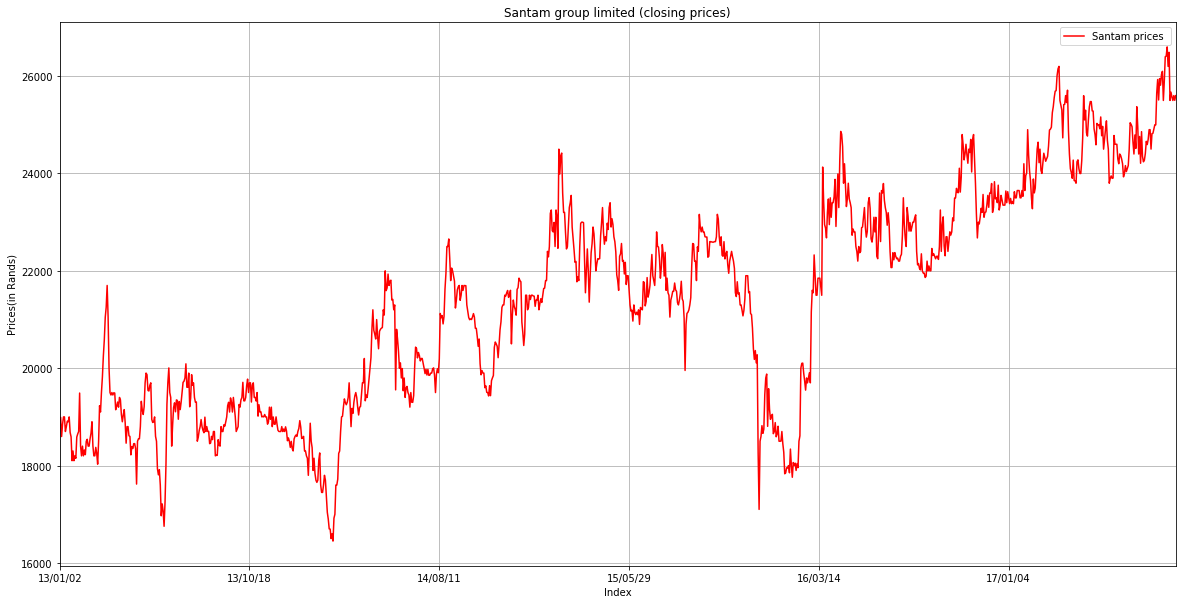

In [20]:
plt.figure(figsize=(20,10))
SantamTS["Close"].plot(label="Santam prices ",color="red")
plt.grid(True)
plt.title("Santam group limited (closing prices)",color="black")
plt.xlabel("Index")
plt.ylabel("Prices(in Rands)")
plt.legend(loc=1)

In [21]:
#The log-returns
returns=np.log((SantamTS["Close"])/(SantamTS["Close"].shift()))
returns.head(5)
returns=returns.dropna()

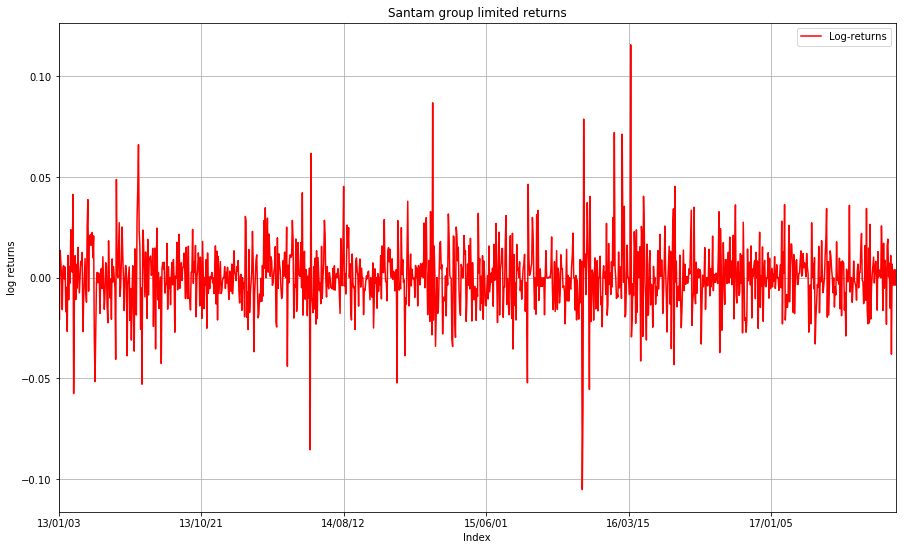

In [22]:
#print("The following plot shows the daily logged return of Netcare group limited")
plt.figure(figsize=(15,9))
returns.plot(label="Log-returns",color="red")
plt.grid(True)
plt.title("Santam group limited returns",color="black")
plt.xlabel("Index")
plt.ylabel("log returns")
plt.legend(loc=0)
plt.show()

In [23]:
#stationarity test for the returns series
#The number of lags can be directly set using lags.
#Changing the number of lags makes no difference to the conclusion
#The ADF assumes residuals are white noise, and that the number of lags is sufficient, 
#to pick up any dependence  in the data.

from arch.unitroot import ADF
adf = ADF(returns)
adf.lags = 15
print(adf.summary().as_text())
print('The ADF test statistic value is less than the critical region and p-value is also less than 0.05 significance level.So we  reject the null hypothesis of non-stationarity of the series and conclude that the returns series is stationary')


   Augmented Dickey-Fuller Results   
Test Statistic                 -9.272
P-value                         0.000
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
The ADF test statistic value is less than the critical region and p-value is also less than 0.05 significance level.So we  reject the null hypothesis of non-stationarity of the series and conclude that the returns series is stationary


#### split1: Train 500  Test:200

In [25]:
SantamTrain=returns[0:500]
SantamTest=returns[500:700]

In [26]:
#summary statistics of the fitted model
ARMA11_model = ARMA11(SantamTrain.as_matrix())
Model_results = ARMA11_model.fit()

print(Model_results.summary())

print'Model: summary'
print 'Both the estimated autoregressive and moving average paramters lies within the 95%\
confidence interval. But, the varince parameter value is very small (almost close to zero).\
The mode estimated standard errors are close to zero.These results indicates that our \
estimated paramters are close to the true values'

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  500
Model:                         ARMA11   Log Likelihood                1374.559
Date:                Thu, 10 May 2018   AIC                          -2743.118
Time:                        03:03:48   BIC                          -2730.475
Sample:                             0   HQIC                         -2738.157
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
phi            0.5524      0.644      0.857      0.391      -0.711       1.815
theta         -0.5825      0.636     -0.916      0.360      -1.829       0.664
sigma2         0.0002   9.12e-06     26.257      0.0

In [27]:
import pandas as pd
from  pandas import Series
print("Long term predictions (test data) 25%:")
import warnings
warnings.filterwarnings("ignore") 
from numpy import sqrt
import statsmodels.tsa.api as smt
history=[x for x in SantamTrain]
test_predicted=list()
for i in range(len(SantamTest)):
    model=ARMA11(history).fit(trend='nc')
    output=model.forecast()
    yhat=output[0]
    test_predicted.append(yhat)
    obs=SantamTest[i]
    history.append(obs)
    AbsoluteError=(np.abs(obs-yhat))
    ForecastError=(obs-yhat)
    print ('Test=%f, Predicted=%f' % (obs,yhat))
SantamTest=list(SantamTest)


Long term predictions (test data) 25%:
Test=-0.009778, Predicted=-0.000016
Test=0.006046, Predicted=0.000285
Test=0.000000, Predicted=-0.000016
Test=0.004662, Predicted=-0.000009
Test=-0.014052, Predicted=-0.000148
Test=0.005973, Predicted=0.000346
Test=0.004725, Predicted=0.000018
Test=-0.003600, Predicted=-0.000137
Test=0.006954, Predicted=0.000033
Test=0.006398, Predicted=-0.000199
Test=0.000323, Predicted=-0.000314
Test=0.007135, Predicted=-0.000193
Test=0.000046, Predicted=-0.000331
Test=0.027105, Predicted=-0.000194
Test=-0.005057, Predicted=-0.000917
Test=0.009512, Predicted=-0.000393
Test=0.029775, Predicted=-0.000506
Test=0.003015, Predicted=-0.001064
Test=-0.018449, Predicted=-0.000675
Test=-0.001096, Predicted=0.000095
Test=0.008516, Predicted=0.000087
Test=-0.021761, Predicted=-0.000194
Test=0.032790, Predicted=0.000527
Test=-0.005953, Predicted=-0.000733
Test=-0.028438, Predicted=-0.000236
Test=0.086759, Predicted=0.000837
Test=-0.021078, Predicted=-0.003309
Test=0.015716,

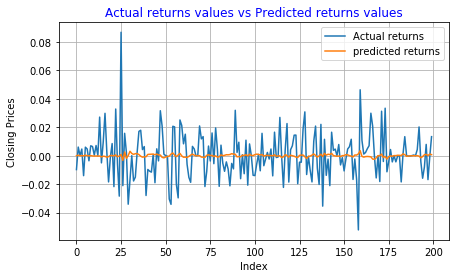

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(SantamTest,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()

In [29]:
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))

print("Predicted data:")
#convert normalised (testing)data to binary 0 or 1
binary_test=[]
for t in range(0,len(SantamTest)):
    if SantamTest[t-1]>=SantamTest[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print "The number of correct direction predictions is:",count,"out of:",len(x),"data points"
counter(binary_test,binary_predicted_test)


([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0], 200)
Predicted data:
([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,

73.0
[[73 28]
 [26 73]]


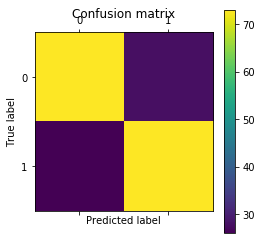

In [30]:
Confusion_matrix(len(SantamTest))

#### split2: Train 700  Test:200

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  700
Model:                         ARMA11   Log Likelihood                1915.653
Date:                Thu, 10 May 2018   AIC                          -3825.306
Time:                        03:07:40   BIC                          -3811.653
Sample:                             0   HQIC                         -3820.028
                                - 700                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
phi            0.5368      0.258      2.082      0.037       0.031       1.042
theta         -0.6020      0.250     -2.408      0.016      -1.092      -0.112
sigma2         0.0002    7.9e-06     31.098      0.0

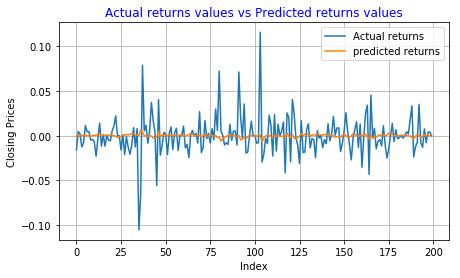

([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0], 200)
Predicted data:
([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,

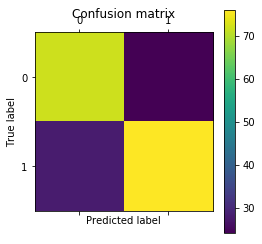

In [31]:
SantamTrain=returns[0:700]#2013-january-01 to 2016-february-16
SantamTest=returns[700:900]#2016-february-17 to 2017-march-01
#summary statistics of the fitted model
ARMA11_model = ARMA11(SantamTrain.as_matrix())
Model_results = ARMA11_model.fit()
print(Model_results.summary())
import pandas as pd
from  pandas import Series
print("Long term predictions (test data) 25%:")
import warnings
warnings.filterwarnings("ignore") 
from numpy import sqrt
import statsmodels.tsa.api as smt
history=[x for x in SantamTrain]
test_predicted=list()
for i in range(len(SantamTest)):
    model=ARMA11(history).fit(trend='nc')
    output=model.forecast()
    yhat=output[0]
    test_predicted.append(yhat)
    obs=SantamTest[i]
    history.append(obs)
    AbsoluteError=(np.abs(obs-yhat))
    ForecastError=(obs-yhat)
    print ('Test=%f, Predicted=%f' % (obs,yhat))
SantamTest=list(SantamTest)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(SantamTest,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))

print("Predicted data:")
#convert normalised (testing)data to binary 0 or 1
binary_test=[]
for t in range(0,len(SantamTest)):
    if SantamTest[t-1]>=SantamTest[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print "The number of correct direction predictions is:",count,"out of:",len(x),"data points"
counter(binary_test,binary_predicted_test)
Confusion_matrix(len(SantamTest))






# Sanlam

Sanlam Limited is a South Africa-based holding company. The Company provides financial solutions to individuals and institutional clients through a network of channels and partnerships in approximately 50 countries. The Company operates through six segments: Sanlam Personal Finance, which is responsible for retail business in South Africa; Sanlam Emerging Markets, which includes general insurance and investment management; Sanlam Investments, which includes Investment Management and Capital Management; Sanlam Corporate, which includes Sanlam Employee Benefits and Sanlam Health Management; Santam, which provides a range of general insurance products and services, and Group office and Other. Its solutions include Life insurance, general insurance, investment management (including retail savings, asset management and wealth management), credit and structuring, and administration health and other (such as estate planning, trusts, wills, and lending and health management). 

In [15]:
#load the data set
filename = 'slm.csv'
SanlamTS = pd.read_csv(filename,na_filter=True,index_col="Date").dropna()
SanlamTS.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
13/01/02,4520.0,4550,4509,4545,2035263
13/01/03,4550.0,4558,4516,4549,1488016
13/01/04,4512.0,4600,4512,4598,1498258
13/01/07,4600.0,4640,4568,4609,1705254
13/01/08,4625.0,4631,4601,4631,1989724


In [16]:
print"The sample contains:", len(SanlamTS),"observations"

The sample contains: 1177 observations


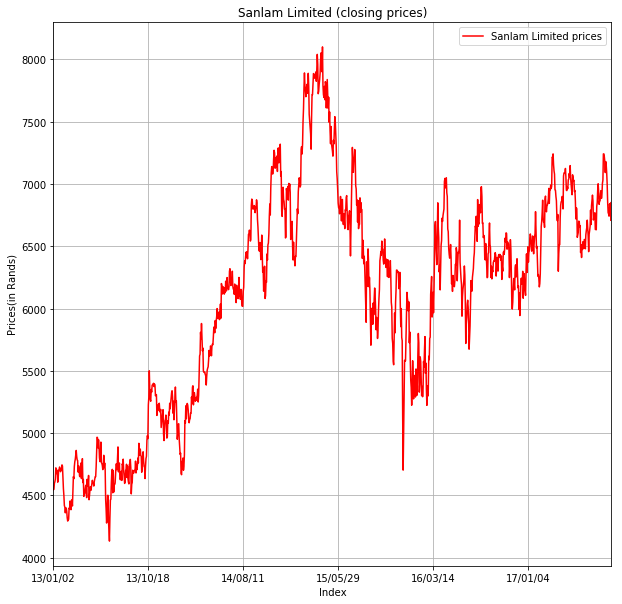

In [17]:
plt.figure(figsize=(10,10))
SanlamTS["Close"].plot(label="Sanlam Limited prices",color="red")
plt.grid(True)
plt.title("Sanlam Limited (closing prices)",color="black")
plt.xlabel("Index")
plt.ylabel("Prices(in Rands)")
plt.legend(loc=1)

In [18]:
#The log-returns
returns=np.log((SanlamTS["Close"])/(SanlamTS["Close"].shift()))
returns.head(5)
returns=returns.dropna()

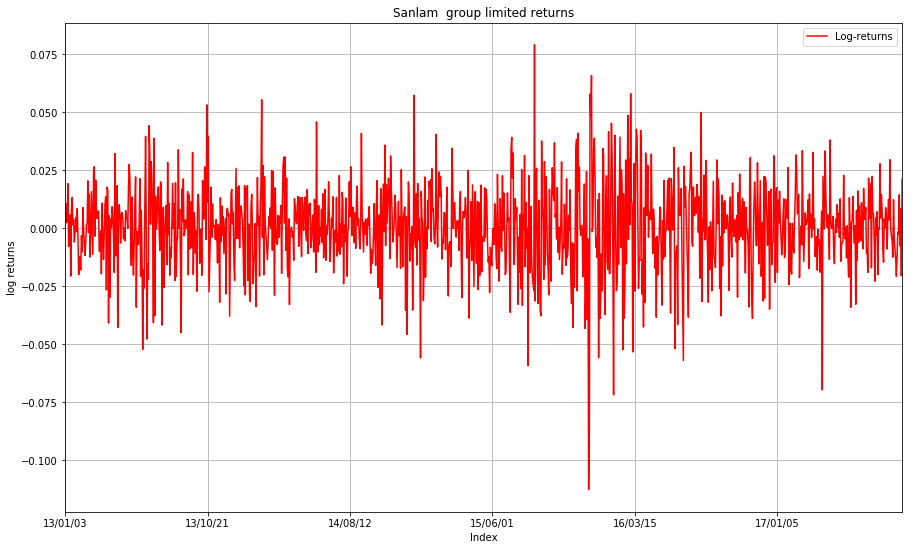

In [19]:
plt.figure(figsize=(15,9))
returns.plot(label="Log-returns",color="red")
plt.grid(True)
plt.title("Sanlam  group limited returns",color="black")
plt.xlabel("Index")
plt.ylabel("log returns")
plt.legend(loc=0)
plt.show()

In [20]:
#stationarity test for the returns series
#The number of lags can be directly set using lags.
#Changing the number of lags makes no difference to the conclusion
#The ADF assumes residuals are white noise, and that the number of lags is sufficient, 
#to pick up any dependence  in the data.

from arch.unitroot import ADF
adf = ADF(returns)
adf.lags = 15
print(adf.summary().as_text())
print('The ADF test statistic value is less than the critical region and p-value is also less than 0.05 significance level.So we  reject the null hypothesis of non-stationarity of the series and conclude that the returns series is stationary')


   Augmented Dickey-Fuller Results   
Test Statistic                 -9.694
P-value                         0.000
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
The ADF test statistic value is less than the critical region and p-value is also less than 0.05 significance level.So we  reject the null hypothesis of non-stationarity of the series and conclude that the returns series is stationary


#### split1: Train 500  Test:200

In [21]:
SanlamTrain=returns[0:500]
SanlamTest=returns[500:700]

In [22]:
#summary statistics of the fitted model
ARMA11_model = ARMA11(SanlamTrain)
Model_results = ARMA11_model.fit()

print(Model_results.summary())

print'Model: summary'
print 'Both the estimated autoregressive and moving average paramters lies within the 95%\
confidence interval. But, the varince parameter value is very small (almost close to zero).\
The mode estimated standard errors are close to zero.These results indicates that our \
estimated paramters are close to the true values'

                           Statespace Model Results                           
Dep. Variable:                  Close   No. Observations:                  500
Model:                         ARMA11   Log Likelihood                1352.542
Date:                Thu, 10 May 2018   AIC                          -2699.084
Time:                        03:36:58   BIC                          -2686.441
Sample:                    01-13-2003   HQIC                         -2694.123
                         - 01-15-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
phi           -0.0704      0.393     -0.179      0.858      -0.841       0.700
theta         -0.0240      0.393     -0.061      0.951      -0.794       0.746
sigma2         0.0003   1.32e-05     19.856      0.0

In [23]:
import pandas as pd
from  pandas import Series
print("Long term predictions (test data) 25%:")
import warnings
warnings.filterwarnings("ignore") 
from numpy import sqrt
import statsmodels.tsa.api as smt
history=[x for x in SanlamTrain]
test_predicted=list()
for i in range(len(SanlamTest)):
    model=ARMA11(history).fit(trend='nc')
    output=model.forecast()
    yhat=output[0]
    test_predicted.append(yhat)
    obs=SanlamTest[i]
    history.append(obs)
    AbsoluteError=(np.abs(obs-yhat))
    ForecastError=(obs-yhat)
    print ('Test=%f, Predicted=%f' % (obs,yhat))
SanlamTest=list(SanlamTest)

Long term predictions (test data) 25%:
Test=0.015891, Predicted=0.005303
Test=0.004494, Predicted=-0.001334
Test=0.001494, Predicted=-0.000544
Test=-0.031229, Predicted=-0.000201
Test=-0.016144, Predicted=0.003059
Test=0.022132, Predicted=0.002033
Test=-0.021193, Predicted=-0.001440
Test=0.000469, Predicted=0.001796
Test=-0.008790, Predicted=0.000278
Test=0.012066, Predicted=0.000917
Test=-0.000312, Predicted=-0.001061
Test=0.020206, Predicted=-0.000147
Test=0.016807, Predicted=-0.002048
Test=0.020950, Predicted=-0.001886
Test=-0.005751, Predicted=-0.002039
Test=0.025695, Predicted=0.000447
Test=0.007467, Predicted=-0.002473
Test=0.008547, Predicted=-0.000664
Test=-0.003837, Predicted=-0.000773
Test=-0.006715, Predicted=0.000387
Test=0.002005, Predicted=0.000614
Test=0.040513, Predicted=-0.000206
Test=0.002881, Predicted=-0.003770
Test=-0.008115, Predicted=-0.000230
Test=0.010851, Predicted=0.000733
Test=0.024293, Predicted=-0.000982
Test=0.013640, Predicted=-0.002234
Test=0.022371, Pr

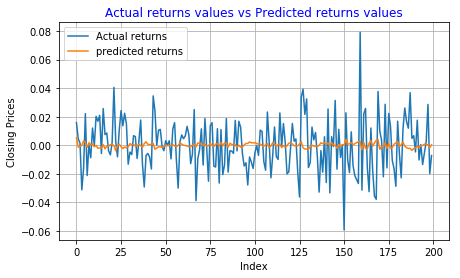

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(SanlamTest,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()

In [25]:
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))

print("Predicted data:")
#convert normalised (testing)data to binary 0 or 1
binary_test=[]
for t in range(0,len(SanlamTest)):
    if SanlamTest[t-1]>=SanlamTest[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print "The number of correct direction predictions is:",count,"out of:",len(x),"data points"
counter(binary_test,binary_predicted_test)

([1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1], 200)
Predicted data:
([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,

69.5
[[70 37]
 [24 69]]


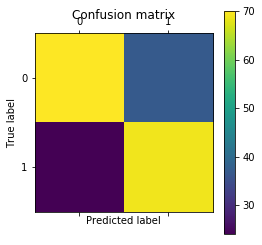

In [26]:
Confusion_matrix(len(SanlamTest))

#### split2: Train 700  Test:200

                           Statespace Model Results                           
Dep. Variable:                  Close   No. Observations:                  700
Model:                         ARMA11   Log Likelihood                1863.130
Date:                Thu, 10 May 2018   AIC                          -3720.260
Time:                        03:40:14   BIC                          -3706.606
Sample:                    01-13-2003   HQIC                         -3714.982
                         - 10-15-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
phi            0.5164      0.317      1.631      0.103      -0.104       1.137
theta         -0.5832      0.297     -1.961      0.050      -1.166      -0.000
sigma2         0.0003   1.24e-05     22.966      0.0

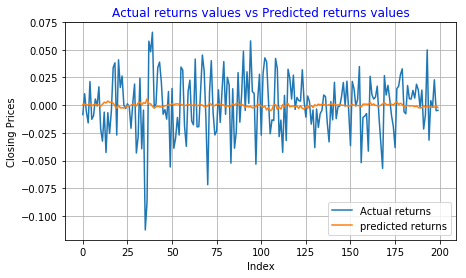

([1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0], 200)
Predicted data:
([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,

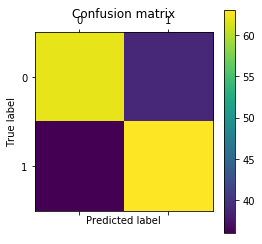

In [27]:
SanlamTrain=returns[0:700]
SanlamTest=returns[700:900]
#summary statistics of the fitted model
ARMA11_model = ARMA11(SanlamTrain)
Model_results = ARMA11_model.fit()
print(Model_results.summary())
import pandas as pd
from  pandas import Series
print("Long term predictions (test data) 25%:")
import warnings
warnings.filterwarnings("ignore") 
from numpy import sqrt
import statsmodels.tsa.api as smt
history=[x for x in SanlamTrain]
test_predicted=list()
for i in range(len(SanlamTest)):
    model=ARMA11(history).fit(trend='nc')
    output=model.forecast()
    yhat=output[0]
    test_predicted.append(yhat)
    obs=SanlamTest[i]
    history.append(obs)
    AbsoluteError=(np.abs(obs-yhat))
    ForecastError=(obs-yhat)
    print ('Test=%f, Predicted=%f' % (obs,yhat))
SanlamTest=list(SanlamTest)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(SanlamTest,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))

print("Predicted data:")
#convert normalised (testing)data to binary 0 or 1
binary_test=[]
for t in range(0,len(SanlamTest)):
    if SanlamTest[t-1]>=SanlamTest[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print "The number of correct direction predictions is:",count,"out of:",len(x),"data points"
counter(binary_test,binary_predicted_test)
Confusion_matrix(len(SanlamTest))



# Nedbank Group Ltd

Nedbank is one of the largest banks in South Africa; however, it is one of the newest banks to be incorporated. It is headquartered in Johannesburg. Market capitalization was ZAR:120 billion (approximately US$9.85 billion), as of 30 June 2015.

In [28]:
#load the data 
filename = 'ned.csv'
nedbankTS = pd.read_csv(filename,na_filter=True,index_col="Date").dropna()
nedbankTS.head(5)


,Open,High,Low,Close,Volume
Date,,,,,
13/01/02,18888,19001,18755,18975,292269
13/01/03,19000,19001,18741,18947,182826
13/01/04,19000,19000,18750,18832,191315
13/01/07,19079,19184,18818,19025,296281
13/01/08,19010,19159,18806,18977,241453


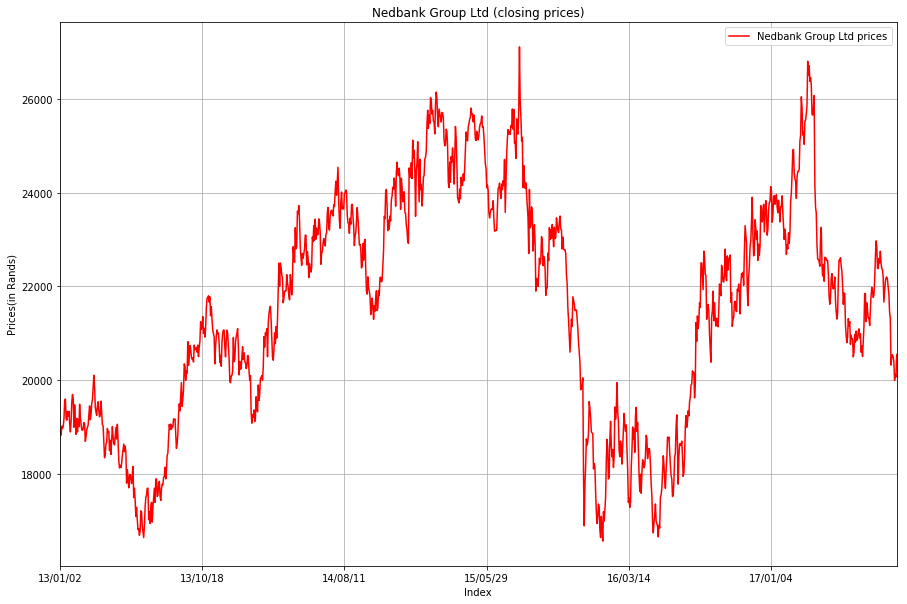

In [29]:
plt.figure(figsize=(15,10))
nedbankTS["Close"].plot(label="Nedbank Group Ltd prices",color="red")
plt.grid(True)
plt.title("Nedbank Group Ltd (closing prices)",color="black")
plt.xlabel("Index")
plt.ylabel("Prices(in Rands)")
plt.legend(loc=1)

In [30]:
#The log-returns
returns=np.log((nedbankTS["Close"])/(nedbankTS["Close"].shift()))
returns.head(5)
returns=returns.dropna()

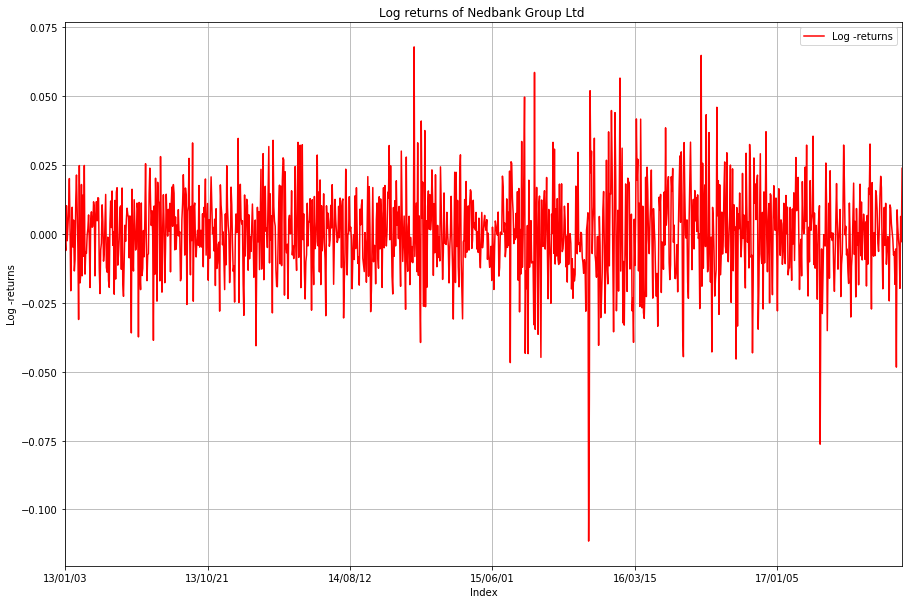

In [31]:
plt.figure(figsize=(15,10))
returns.plot(label="Log -returns",color="red")
plt.grid(True)
plt.title("Log returns of Nedbank Group Ltd ",color="black")
plt.xlabel("Index")
plt.ylabel("Log -returns")
plt.legend(loc=1)

In [32]:
#stationarity test for the returns series
#The number of lags can be directly set using lags.
#Changing the number of lags makes no difference to the conclusion
#The ADF assumes residuals are white noise, and that the number of lags is sufficient, 
#to pick up any dependence  in the data.

from arch.unitroot import ADF
adf = ADF(returns)
adf.lags = 15
print(adf.summary().as_text())
print('The ADF test statistic value is less than the critical region and p-value is also less than 0.05 significance level.So we  reject the null hypothesis of non-stationarity of the series and conclude that the returns series is stationary')


   Augmented Dickey-Fuller Results   
Test Statistic                 -8.738
P-value                         0.000
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
The ADF test statistic value is less than the critical region and p-value is also less than 0.05 significance level.So we  reject the null hypothesis of non-stationarity of the series and conclude that the returns series is stationary


In [33]:
#stationarity test for the returns series
#The number of lags can be directly set using lags.
#Changing the number of lags makes no difference to the conclusion
#The ADF assumes residuals are white noise, and that the number of lags is sufficient, 
#to pick up any dependence  in the data.

from arch.unitroot import ADF
adf = ADF(returns)
adf.lags = 15
print(adf.summary().as_text())
print('The ADF test statistic value is less than the critical region and p-value is also less than 0.05 significance level.So we  reject the null hypothesis of non-stationarity of the series and conclude that the returns series is stationary')


   Augmented Dickey-Fuller Results   
Test Statistic                 -8.738
P-value                         0.000
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
The ADF test statistic value is less than the critical region and p-value is also less than 0.05 significance level.So we  reject the null hypothesis of non-stationarity of the series and conclude that the returns series is stationary


#### split1: Train 500  Test:200

In [34]:
nedbankTrain=returns[0:500]
nedbankTest=returns[500:700]

In [35]:
#summary statistics of the fitted model
ARMA11_model = ARMA11(nedbankTrain)
Model_results = ARMA11_model.fit()

print(Model_results.summary())

print'Model: summary'
print 'Both the estimated autoregressive and moving average paramters lies within the 95%\
confidence interval. But, the varince parameter value is very small (almost close to zero).\
The mode estimated standard errors are close to zero.These results indicates that our \
estimated paramters are close to the true values'

                           Statespace Model Results                           
Dep. Variable:                  Close   No. Observations:                  500
Model:                         ARMA11   Log Likelihood                1430.199
Date:                Thu, 10 May 2018   AIC                          -2854.398
Time:                        03:44:10   BIC                          -2841.754
Sample:                    01-13-2003   HQIC                         -2849.436
                         - 01-15-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
phi            0.5955      0.157      3.789      0.000       0.288       0.904
theta         -0.7221      0.132     -5.489      0.000      -0.980      -0.464
sigma2         0.0002   1.04e-05     18.458      0.0

In [36]:
import pandas as pd
from  pandas import Series
print("Long term predictions (test data) 25%:")
import warnings
warnings.filterwarnings("ignore") 
from numpy import sqrt
import statsmodels.tsa.api as smt
history=[x for x in nedbankTrain]
test_predicted=list()
for i in range(len(nedbankTest)):
    model=ARMA11(history).fit(trend='nc')
    output=model.forecast()
    yhat=output[0]
    test_predicted.append(yhat)
    obs=nedbankTest[i]
    history.append(obs)
    AbsoluteError=(np.abs(obs-yhat))
    ForecastError=(obs-yhat)
    print ('Test=%f, Predicted=%f' % (obs,yhat))
nedbankTest=list(nedbankTest)

Long term predictions (test data) 25%:
Test=0.040905, Predicted=0.005686
Test=0.005744, Predicted=-0.001700
Test=0.018753, Predicted=-0.001915
Test=-0.026256, Predicted=-0.003933
Test=-0.026249, Predicted=0.001427
Test=0.037441, Predicted=0.004384
Test=-0.026452, Predicted=-0.002704
Test=0.004685, Predicted=0.002497
Test=-0.019379, Predicted=0.000826
Test=0.009987, Predicted=0.003605
Test=0.015536, Predicted=0.000686
Test=0.001684, Predicted=-0.001748
Test=0.014222, Predicted=-0.001571
Test=0.001415, Predicted=-0.003155
Test=0.004998, Predicted=-0.002384
Test=0.023168, Predicted=-0.002390
Test=0.011638, Predicted=-0.005040
Test=-0.015101, Predicted=-0.004729
Test=0.010938, Predicted=-0.001308
Test=-0.006886, Predicted=-0.002139
Test=0.021401, Predicted=-0.000646
Test=-0.001615, Predicted=-0.003455
Test=-0.011965, Predicted=-0.001913
Test=0.003034, Predicted=0.000634
Test=-0.008580, Predicted=-0.000069
Test=-0.001176, Predicted=0.001127
Test=-0.009852, Predicted=0.000926
Test=0.024258, 

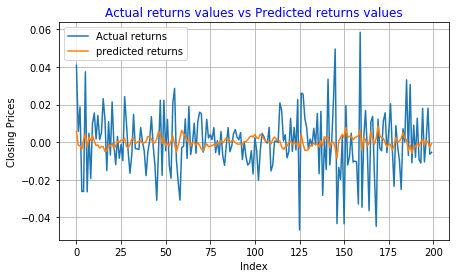

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(nedbankTest,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()

In [38]:
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))

print("Predicted data:")
#convert normalised (testing)data to binary 0 or 1
binary_test=[]
for t in range(0,len(nedbankTest)):
    if nedbankTest[t-1]>=nedbankTest[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print "The number of correct direction predictions is:",count,"out of:",len(x),"data points"
counter(binary_test,binary_predicted_test)

([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1], 200)
Predicted data:
([1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,

73.5
[[73 28]
 [25 74]]


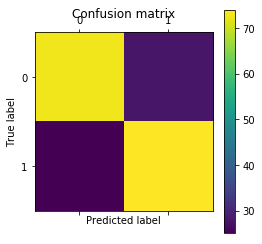

In [39]:
Confusion_matrix(len(nedbankTest))

#### split2: Train 700  Test:200

                           Statespace Model Results                           
Dep. Variable:                  Close   No. Observations:                  700
Model:                         ARMA11   Log Likelihood                1972.910
Date:                Thu, 10 May 2018   AIC                          -3939.819
Time:                        03:49:42   BIC                          -3926.166
Sample:                    01-13-2003   HQIC                         -3934.541
                         - 10-15-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
phi            0.4628      0.138      3.349      0.001       0.192       0.734
theta         -0.6247      0.123     -5.077      0.000      -0.866      -0.384
sigma2         0.0002   9.24e-06     22.572      0.0

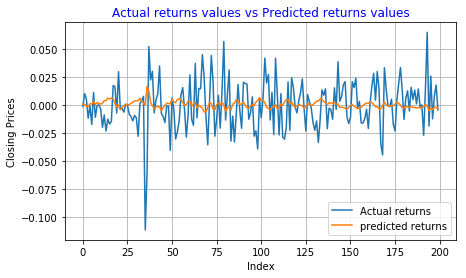

([1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0], 200)
Predicted data:
([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,

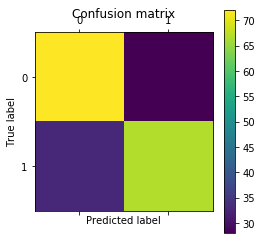

In [40]:
nedbankTrain=returns[0:700]
nedbankTest=returns[700:900]
#summary statistics of the fitted model
ARMA11_model = ARMA11(nedbankTrain)
Model_results = ARMA11_model.fit()
print(Model_results.summary())
import pandas as pd
from  pandas import Series
print("Long term predictions (test data) 25%:")
import warnings
warnings.filterwarnings("ignore") 
from numpy import sqrt
import statsmodels.tsa.api as smt
history=[x for x in nedbankTrain]
test_predicted=list()
for i in range(len(nedbankTest)):
    model=ARMA11(history).fit(trend='nc')
    output=model.forecast()
    yhat=output[0]
    test_predicted.append(yhat)
    obs=nedbankTest[i]
    history.append(obs)
    AbsoluteError=(np.abs(obs-yhat))
    ForecastError=(obs-yhat)
    print ('Test=%f, Predicted=%f' % (obs,yhat))
nedbankTest=list(nedbankTest)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(nedbankTest,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))

print("Predicted data:")
#convert normalised (testing)data to binary 0 or 1
binary_test=[]
for t in range(0,len(nedbankTest)):
    if nedbankTest[t-1]>=nedbankTest[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print "The number of correct direction predictions is:",count,"out of:",len(x),"data points"
counter(binary_test,binary_predicted_test)
Confusion_matrix(len(nedbankTest))

### Summary results for predictions

In [ ]:
import pandas as pd
steps=[[77.0,74.5],[73.0,74.0],[74.0,69.5],[69.5,62.5]]

In [ ]:
data=pd.DataFrame(steps,index=['Netcare','Santam','Nedbank','Sanlam'],columns=["Train:500 Test:200","Train:700 Test:200"])

In [ ]:
print 'Accuracy for StateSpace ARMA(1,1) (percentage)'
data